# Import bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import scikit_posthocs as sp
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sa

Ustawienie wielkości wykresów i biblioteki matplotlib.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

# Wczytanie danych

In [3]:
dane = pd.read_csv('../dane/dane.csv', sep=',')
dane.head()

,city,date,year,month,day,high_temp,avg_temp,low_temp,high_dewpt,avg_dewpt,...,high_wind,avg_wind,max_wind_gust,precip,events,Rain,Fog,Thunderstorm,Snow,Hail
0,Auckland,2016-01-01,2016,1,1,20.00,18.33,16.67,17.78,15.56,...,33.80,24.14,45.06,0.03,Rain,1.0,0.0,0.0,0.0,0.0
1,Auckland,2016-01-02,2016,1,2,20.00,18.89,17.78,17.78,17.22,...,53.11,33.80,74.03,0.03,Rain,1.0,0.0,0.0,0.0,0.0
2,Auckland,2016-01-03,2016,1,3,25.00,22.22,18.89,21.11,19.44,...,28.97,19.31,0.00,0.03,Rain,1.0,0.0,0.0,0.0,0.0
3,Auckland,2016-01-04,2016,1,4,22.78,18.89,15.56,18.89,15.56,...,24.14,16.09,0.00,0.03,Rain,1.0,0.0,0.0,0.0,0.0
4,Auckland,2016-01-05,2016,1,5,20.56,16.67,12.78,12.78,11.11,...,20.92,11.27,0.00,0.00,No event,0.0,0.0,0.0,0.0,0.0


# Testowanie normalności

Sprawdźmy, czy nasze dane posiadają rozkład normalny (jest to założenie wielu testów statystycznych).

Na początek sprawdźmy, czy dane posiadają łączny rozkład normalny (wielowymiarowy rozkład normalny) za pomocą testu Shapiro-Wilka z biblioteki scipy. 

In [4]:
stats.shapiro(dane.iloc[:, 5:24])

c:\users\weronika\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.4925258755683899, 0.0)

Widzimy, iż p-wartość sugeruje odrzucenie hipotezy zerowej o rozkładzie normalnym.

Przetestujmy jeszcze rozkłady każdej z cech numerycznych z osobna.

In [5]:
stats.normaltest(dane.iloc[:, 5:24], axis=0, nan_policy='propagate')

NormaltestResult(statistic=array([ 292.12592276,  399.59916697,  409.14713036,  491.7977685 ,
        441.66920408,  360.1714732 ,  807.54278587,  276.24096498,
        408.23670958,  157.82616634,   91.43711575,   35.90021891,
        299.31231084,   50.57097696,  663.4578652 , 3241.15546954,
        776.65749775,  168.01790703, 6683.23610999]), pvalue=array([3.67842464e-064, 1.69099921e-087, 1.42833309e-089, 1.61239508e-107,
       1.23808631e-096, 6.16251976e-079, 4.40871573e-176, 1.03522945e-060,
       2.25177431e-089, 5.35159734e-035, 1.39534819e-020, 1.60090851e-008,
       1.01194642e-065, 1.04388313e-011, 8.54978285e-145, 0.00000000e+000,
       2.24371245e-169, 3.27623509e-037, 0.00000000e+000]))

Dla każdej z cech test sugeruje odrzucenie hipotezy o normalności rozkładu.

Poniżej jeszcze wyniki kilku innych testów normalności wykonanych za pomocą funkcji mvn z pakietu MVN środowiska R:

Widać, że nie jest to wielowymiarowy normalny jak i każda zmienna indywidualnie też nie posiada tego rozkładu. Nie możemy więc zastosować testów opartych na rozkładzie normalnym dla szukania obserwacji odstających, jak i dla porównania średnich (t-test, anova). Zastosujemy więc technikę isolation forest dla szukania obserwacji odstających oraz testy nieparametryczne na potrzeby dalszych analiz.

# Usuwanie obserwacji odstających

Zastosujemy technikę, która nie wymaga założenia konkretnego rozkładu - isolation forest.

## Inicjalizacja klasy i dopasowanie algorytmu

In [6]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(dane.iloc[:, 5:24])

IsolationForest(bootstrap=False, contamination=0.12, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=42,
        verbose=0)

## Oznaczenie obserwacji odstających

In [7]:
pred = clf.predict(dane.iloc[:, 5:24])
dane['anomaly'] = pred
outliers = dane.loc[dane['anomaly'] == -1]
outlier_index = list(outliers.index)

Sprawdźmy ilość obserwacji odstających (oznaczone one są przez -1) oraz policzmy ich stosunek do całości zbioru.

In [8]:
count = dane['anomaly'].value_counts()
print(count)
count.tolist()[1]/sum(count.tolist())

 1    3216
-1     439
Name: anomaly, dtype: int64


0.120109439124487

Widzimy, że stanowią one około 12 procent zbioru. Możemy usunąć takie obserwacje lub zastąpić ich wartość średnią wartością dla danego miasta i wydarzenia.

Możemy to zrobić np. w następujący sposób:

In [9]:
dane2 = dane[dane.anomaly != -1]
dane2.shape

(3216, 31)

Porównajmy dane bez obs. odstających do wszystkich danych (czy np nie wskazano konkretnego miasta czy wydarzenia jako dane do usunięcia z powodu ich odmienności).

In [10]:
print(dane.city.value_counts())
print(dane2.city.value_counts())

San Diego    731
Auckland     731
Mumbai       731
Beijing      731
Chicago      731
Name: city, dtype: int64
Auckland     729
San Diego    720
Mumbai       693
Chicago      607
Beijing      467
Name: city, dtype: int64


Możemy zauważyć, że większość usuniętych obserwacji pochodzi z miasta Pekin, czego można było się spodziewać patrząc na wykresy typu boxplot. Wszystkie z miast zostały zachowane, co umożliwia dalszą analizę.

In [11]:
print(dane.events.value_counts())
print('Ilość typów wydarzeń oryginalnie:', dane.events.value_counts().shape[0])
print('\n')
print(dane2.events.value_counts())
print('Ilość typów wydarzeń po usunięciu:', dane2.events.value_counts().shape[0])

No event                      2217
Rain                           910
Rain , Thunderstorm            229
Fog                            115
Snow                            66
Fog , Rain                      44
Thunderstorm                    18
Rain , Snow                     15
Fog , Snow                      12
Fog , Rain , Thunderstorm       10
Rain , Hail                      7
Fog , Rain , Snow                5
Rain , Hail , Thunderstorm       5
Fog , Snow , Thunderstorm        1
Fog , Thunderstorm               1
Name: events, dtype: int64
Ilość typów wydarzeń oryginalnie: 15


No event                      1938
Rain                           869
Rain , Thunderstorm            200
Fog                            107
Fog , Rain                      41
Thunderstorm                    17
Snow                            14
Fog , Rain , Thunderstorm        8
Rain , Snow                      7
Rain , Hail                      7
Rain , Hail , Thunderstorm       4
Fog , Rain , Snow       

Widzimy, że najwięcej obserwacji usunięto z wydarzenia z opadami śniegu, czego można było się spodziewać patrząc na występujące wtedy niskie temperatury a ogólnie wysokie średnie temperatur i wysokie wartości pierwszego kwartyla dla temperatur. Usunięto kilka kategorii, co dla analiz dla wydarzeń nie jest korzystne.

Zilustrujmy teraz wykryty podział na obserwacje "poprawne" i obserwacje odstające rzutując zmienne do 3 wymiarów.

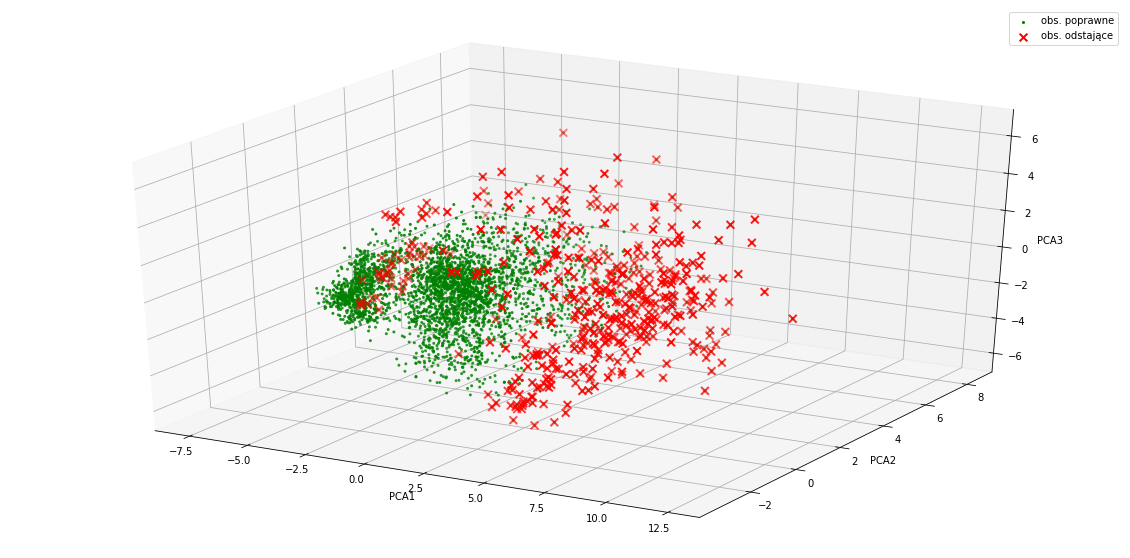

In [12]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
X = scaler.fit_transform(dane.iloc[:, 5:24])
X_reduce = pca.fit_transform(X)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="obs. poprawne",c="green")
ax.scatter(X_reduce[outlier_index, 0],X_reduce[outlier_index, 1], X_reduce[outlier_index, 2],
           lw=2, s=60, marker="x", c="red", label="obs. odstające")
ax.legend()
plt.show()

Widzimy faktyczne odstawanie obserwacji odstających.

# Porównanie różnic w medianach między grupami dla średniej temperatury

Chcemy sprawdzić, czy sensowne jest rozróżnianie danych dla różnych kategorii - czy ich mediany (test nieparametryczny ze względu na brak normalności danych) są statystycznie różne. Zastosujemy test Kruskala-Wallisa (mamy wiele grup o rozkładzie nieznanym, innym niż normalny). Zrobimy to przykładowo dla temperatur występujących w różnych miastach i przy różnych wydarzeniach. Sprawdzimy, które kategorie są istotnie różne za pomocą testów post-hoc (oczywiście nieparametrycznych).

## Test dla miast

In [13]:
y = []
for ids, city in enumerate(pd.unique(dane.city)):
    y.append(dane[dane.city == city].iloc[:, 5:24].avg_temp)

stats.kruskal(*y)

KruskalResult(statistic=1597.3916679433844, pvalue=0.0)

Widzimy, że test sugeruje odrzucenie hipotezy zerowej o braku różnic między miastami na każdym sensownym poziomie istotności.

## Test dla wydarzeń

In [14]:
y = []
for ids, event in enumerate(pd.unique(dane.events)):
    y.append(dane[dane.events == event].iloc[:, 5:24].avg_temp)

stats.kruskal(*y)

KruskalResult(statistic=433.44398792519627, pvalue=1.1195779869362076e-83)

Podobnie dla różnych wydarzeń widzimy, że test sugeruje odrzucenie hipotezy zerowej o braku różnic między wydarzeniami na każdym sensownym poziomie istotności.

## Testy post-hoc dla wydarzeń

Przykładowo użyjemy testu Conover'a.

In [15]:
y = []
for ids, event in enumerate(pd.unique(dane.events)):
    y.append(dane[dane.events == event].iloc[:, 5:24].avg_temp.tolist())

pc = sp.posthoc_conover(y)
pc

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,-1.000000e+00,5.009844e-03,0.366873,1.800622e-08,4.614838e-20,0.377633,5.519862e-07,2.069811e-07,4.068301e-03,1.902930e-38,1.673971e-08,0.328202,1.692710e-08,7.482139e-04,0.086722
2,5.009844e-03,-1.000000e+00,0.209857,1.288242e-10,2.484021e-16,0.239510,2.468223e-10,1.954548e-06,8.515290e-03,5.179963e-45,1.105187e-09,0.385637,1.525107e-09,2.912086e-04,0.068159
3,3.668732e-01,2.098569e-01,-1.000000,9.555972e-02,2.720998e-03,0.922670,5.251734e-01,1.118798e-04,4.032174e-03,4.552416e-05,3.714571e-03,0.227715,1.555623e-03,2.523943e-02,0.173605
4,1.800622e-08,1.288242e-10,0.095560,-1.000000e+00,6.720244e-21,0.187668,3.466909e-02,5.931116e-14,4.872138e-06,3.923590e-05,4.441856e-02,0.067518,1.785274e-02,1.737441e-01,0.404380
5,4.614838e-20,2.484021e-16,0.002721,6.720244e-21,-1.000000e+00,0.008077,1.351242e-24,2.311307e-02,1.794608e-01,2.031126e-61,8.504046e-16,0.767520,5.405420e-15,1.248531e-06,0.016841
6,3.776326e-01,2.395102e-01,0.922670,1.876680e-01,8.077060e-03,-1.000000,6.779718e-01,4.178151e-04,5.576926e-03,7.741073e-04,1.300338e-02,0.219382,5.985652e-03,4.425606e-02,0.196971
7,5.519862e-07,2.468223e-10,0.525173,3.466909e-02,1.351242e-24,0.677972,-1.000000e+00,8.984522e-12,9.453826e-05,3.359664e-14,3.836068e-04,0.142058,1.601866e-04,2.611280e-02,0.225345
8,2.069811e-07,1.954548e-06,0.000112,5.931116e-14,2.311307e-02,0.000418,8.984522e-12,-1.000000e+00,9.201326e-01,1.847373e-27,1.152333e-14,0.800228,1.371154e-14,5.588543e-08,0.004076
9,4.068301e-03,8.515290e-03,0.004032,4.872138e-06,1.794608e-01,0.005577,9.453826e-05,9.201326e-01,-1.000000e+00,1.937246e-10,9.477831e-08,0.776714,3.880323e-08,9.670225e-06,0.006141
10,1.902930e-38,5.179963e-45,0.000046,3.923590e-05,2.031126e-61,0.000774,3.359664e-14,1.847373e-27,1.937246e-10,-1.000000e+00,4.843385e-01,0.008553,9.250639e-01,7.314905e-01,0.966693


1 Rain
2 No event
3 Fog , Rain , Thunderstorm
4 Fog , Rain
5 Rain , Thunderstorm
6 Rain , Hail
7 Fog
8 Thunderstorm
9 Rain , Hail , Thunderstorm
10 Snow
11 Rain , Snow
12 Fog , Thunderstorm
13 Fog , Snow
14 Fog , Rain , Snow
15 Fog , Snow , Thunderstorm


(<matplotlib.axes._subplots.AxesSubplot at 0x18f531b8358>,
 <matplotlib.colorbar.ColorbarBase at 0x18f52976ba8>)

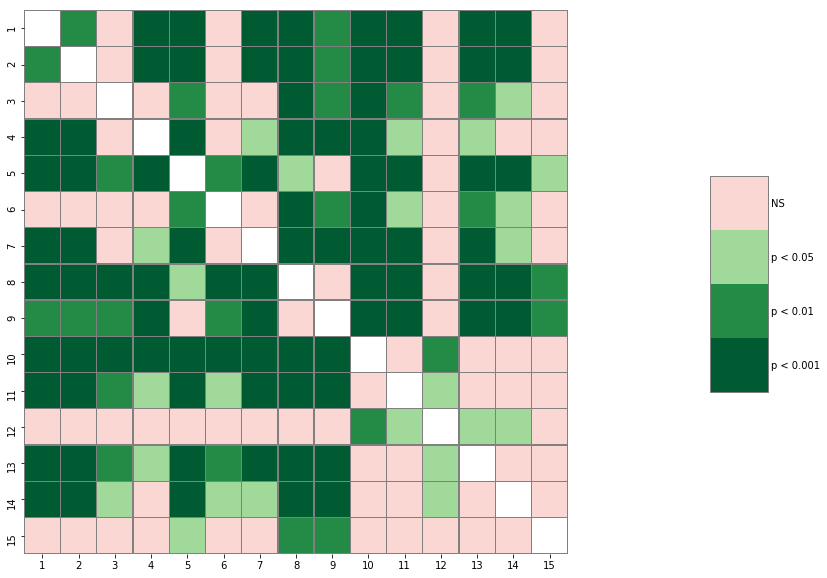

In [16]:
[print(nr + 1, i) for nr, i in enumerate(pd.unique(dane.events))]
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

Widzimy różnice w większości grup. Grupa 15 wykazuje brak różnic z większością, jednak grupa ta jest zbyt mała dla sensownych porównań. Różnice te zauważałyśmy także na boxplotach a odrzucenie hipotez testów post-hoc je potwierdziło. Wydarzenia takie jak śnieg i deszcz różnią się warunkami atmosferycznymi jak temperatura otoczenia, więc można było się spodziewać różnic.

## Testy post-hoc dla miast

Przykładowo użyjemy testu Dunn'a.

In [17]:
y = []
for ids, city in enumerate(pd.unique(dane.city)):
    y.append(dane[dane.city == city].iloc[:, 5:24].avg_temp.tolist())

pc =sp.posthoc_dunn(y)
pc

,1,2,3,4,5
1,-1.000000e+00,2.440807e-225,2.534713e-01,1.608605e-02,1.325673e-19
2,2.440807e-225,-1.000000e+00,1.031631e-209,3.970014e-260,6.081976e-117
3,2.534713e-01,1.031631e-209,-1.000000e+00,3.868209e-04,2.447112e-15
4,1.608605e-02,3.970014e-260,3.868209e-04,-1.000000e+00,1.973003e-30
5,1.325673e-19,6.081976e-117,2.447112e-15,1.973003e-30,-1.000000e+00


1 Auckland
2 Mumbai
3 Beijing
4 Chicago
5 San Diego


(<matplotlib.axes._subplots.AxesSubplot at 0x18f5293b940>,
 <matplotlib.colorbar.ColorbarBase at 0x18f52bed6a0>)

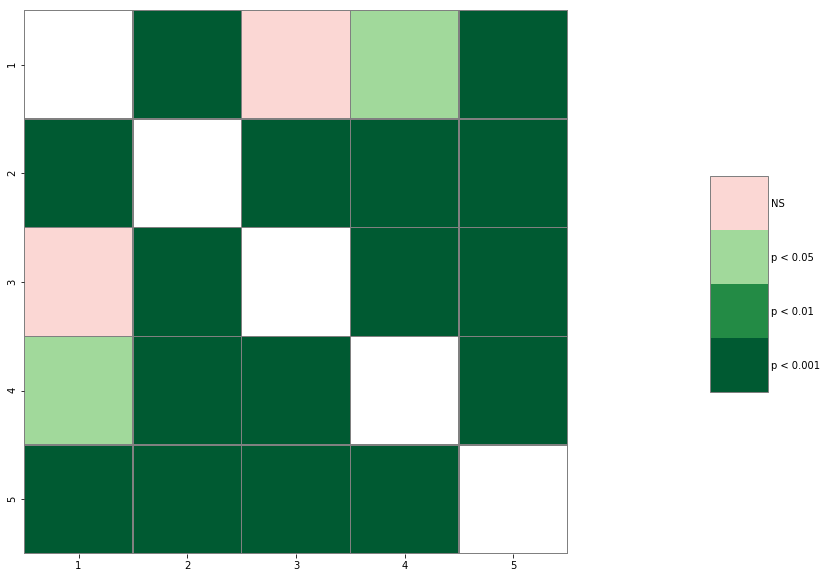

In [18]:
[print(nr + 1, i) for nr, i in enumerate(pd.unique(dane.city))]
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

Widzimy różnice w większości grup. Grupa 3 i 4 wykazuje brak różnic, przekrój tych grup na boxplocie był różny, aczkolwiek średnie i mediany są podobne, co sprawdzają te testy. Różnice te zauważaliśmy także na boxplotach a odrzucenie hipotez testów post-hoc je potwierdziło.

# Klasyfikacja za pomocą regresji logistycznej

Spróbujmy zaklasyfikować typ wydarzenia za pomocą np. regresji logistycznej. Zrobimy to dla każdego wydarzenia z osobna a później połączymy je w wspólne wydarzenie, ze względu na bardzo małą ilość niektórych z łączonych wydarzeń.

Przypomnijmy sobie, jakie pojedyncze wydarzenia występują w zbiorze.

In [19]:
dane.iloc[:, 25:30].columns

Index(['Rain', 'Fog', 'Thunderstorm', 'Snow', 'Hail'], dtype='object')

## Utworzenie zbioru uczącego i testowego

Dla celów sprawdzenia jakości klasyfikacji podzielmy zbiór na dwie części.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
     dane.iloc[:,0:24], dane.iloc[:,24:30], test_size=0.33, random_state=42)

[i.shape for i in [X_train, X_test, y_train, y_test]]

[(2448, 24), (1207, 24), (2448, 6), (1207, 6)]

## Klasyfikacja

Klasyfikacja zmiennej deszcz

In [21]:
clf = LogisticRegression().fit(X_train.iloc[:, 5:], y_train.Rain)
print(clf.predict(X_test.iloc[:, 5:]))
print(clf.score(X_test.iloc[:, 5:], y_test.Rain))
y_test['RainPredict'] = clf.predict(X_test.iloc[:, 5:])

[1. 1. 0. ... 0. 0. 0.]
0.8732394366197183


Klasyfikacja zmiennej mgła

In [22]:
clf = LogisticRegression().fit(X_train.iloc[:, 5:], y_train.Fog)
print(clf.predict(X_test.iloc[:, 5:]))
print(clf.score(X_test.iloc[:, 5:], y_test.Fog))
y_test['FogPredict'] = clf.predict(X_test.iloc[:, 5:])

[0. 0. 1. ... 0. 0. 0.]
0.9784589892294946


Klasyfikacja zmiennej burzy z piorunami.

In [23]:
clf = LogisticRegression().fit(X_train.iloc[:, 5:], y_train.Thunderstorm)
print(clf.predict(X_test.iloc[:, 5:]))
print(clf.score(X_test.iloc[:, 5:], y_test.Thunderstorm))
y_test['ThunderstormPredict'] = clf.predict(X_test.iloc[:, 5:])

[0. 0. 0. ... 0. 0. 0.]
0.9370339685169843


Klasyfikacja zmiennej śnieg

In [24]:
clf = LogisticRegression().fit(X_train.iloc[:, 5:], y_train.Snow)
print(clf.predict(X_test.iloc[:, 5:]))
print(clf.score(X_test.iloc[:, 5:], y_test.Snow))
y_test['SnowPredict'] = clf.predict(X_test.iloc[:, 5:])

[0. 0. 0. ... 0. 0. 0.]
0.9867439933719967


Klasyfikacja zmiennej grad

In [25]:
clf = LogisticRegression().fit(X_train.iloc[:, 5:], y_train.Hail)
print(clf.predict(X_test.iloc[:, 5:]))
print(clf.score(X_test.iloc[:, 5:], y_test.Hail))
y_test['HailPredict'] = clf.predict(X_test.iloc[:, 5:])

[0. 0. 0. ... 0. 0. 0.]
0.9925434962717481


Widzimy całkiem wysoką dokładność (accuracy) dopasowania dla wszystkich typów wydarzeń. Pamiętajmy jednak, że osobna predykcja spowoduje większy odsetek błędów niż łączna.

In [26]:
def change(x):
    y_test[x + 'Predict'] = y_test[x + 'Predict'].map({0: 'No event', 1: x}).fillna('No event')

Podejrzyjmy efekty naszej pracy.

In [27]:
y_test

,events,Rain,Fog,Thunderstorm,Snow,Hail,RainPredict,FogPredict,ThunderstormPredict,SnowPredict,HailPredict
1313,No event,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1674,"Rain , Thunderstorm",1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
229,Fog,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3510,No event,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,Rain,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,No event,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
761,No event,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2656,No event,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
736,No event,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2972,Rain,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Klasyfikacja miasta za pomocą knn

Spróbujmy na podstawie obserwacji odgadnąć, jakie miasto klasyfikujemy. Dla przykładu wykorzystajmy algorytm k najbliższych sąsiadów.

## Podział na zbiór uczący i testowy.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
     dane.iloc[:, 5:24], dane.iloc[:, 0], test_size=0.33, random_state=42)

[i.shape for i in [X_train, X_test, y_train, y_test]]

[(2448, 19), (1207, 19), (2448,), (1207,)]

## Klasyfikacja

In [29]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train) 
print(knn.predict(X_test))
print(knn.score(X_test, y_test))

['Mumbai' 'Beijing' 'Auckland' ... 'San Diego' 'San Diego' 'San Diego']
0.9428334714167357


Widzimy bardzo wysoką skuteczność klasyfikacji. Mogliśmy się tego spodziewać obserwując różnice dla miast na wykresach i w testach statystycznych.

A teraz sprawdźmy, czy usunięcie obserwacji odstających podniesie skuteczność klasyfikacji. W tym celu wygenerujmy z tym samym ziarnem losowym zbiory testowe i uczące, dopasujmy model i obliczmy skuteczność.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
     dane2.iloc[:, 5:24], dane2.iloc[:, 0], test_size=0.33, random_state=42)

[i.shape for i in [X_train, X_test, y_train, y_test]]

[(2154, 19), (1062, 19), (2154,), (1062,)]

In [31]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train) 
print(knn.predict(X_test))
print(knn.score(X_test, y_test))

['Mumbai' 'Auckland' 'San Diego' ... 'Mumbai' 'San Diego' 'Chicago']
0.9453860640301318


Widzimy, że jakość klasyfikacji nieznacznie wzrosła. Musimy też pamiętać, że tu model był uczony na mniejszej liczbie obserwacji.